In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

Using TensorFlow backend.


# Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
TRAINING_SIZE = 80000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789* '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '*',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

# Data Generation

In [7]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    a = np.random.randint(1, 999+1)
    b = np.random.randint(1, 999+1)
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    q = '{}*{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a * b)
    ans += ' ' * (DIGITS*2 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [8]:
print(questions[:5], expected[:5])

['238*689', '953*486', '677*725', '393*111', '523*145'] ['163982', '463158', '490825', '43623 ', '75835 ']


# Processing

In [9]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS * 2, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS * 2)

Vectorization...


In [10]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]
train_y = y[:20000]
test_x = x[20000:]
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 12)
(18000, 6, 12)
Validation Data:
(2000, 7, 12)
(2000, 6, 12)
Testing Data:
(60000, 7, 12)
(60000, 6, 12)


In [11]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False False False  True False False False False False
   False]
  [False False False False False False False False False  True False
   False]
  [False False False False False False False  True False False False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False False False False False False False
    True]
  [False False  True False False False False False False False False
   False]
  [False False False False False False False False False  True False
   False]]

 [[False False False  True False False False False False False False
   False]
  [False False False False False False False  True False False False
   False]
  [False False False False False False False  True False False False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False  True False False False False False
   False]
  [False False False False False False Fal

# Build Model

In [12]:
print('Build model...')
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

############################################
##### Build your own model here ############
############################################
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS * 2))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Build model...
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 6, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 6, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


# Training

Instructions for updating:
Use tf.cast instead.
Train on 18000 samples, validate on 2000 samples
Epoch 1/200
18000/18000 [==============================] - 5s 288us/step - loss: 2.1919 - acc: 0.1924 - val_loss: 2.1026 - val_acc: 0.2158
Epoch 2/200
18000/18000 [==============================] - 3s 176us/step - loss: 2.0791 - acc: 0.2152 - val_loss: 2.0511 - val_acc: 0.2228
Epoch 3/200
18000/18000 [==============================] - 3s 175us/step - loss: 2.0436 - acc: 0.2215 - val_loss: 2.0248 - val_acc: 0.2309
Epoch 4/200
18000/18000 [==============================] - 3s 172us/step - loss: 2.0117 - acc: 0.2304 - val_loss: 1.9968 - val_acc: 0.2348
Epoch 5/200
18000/18000 [==============================] - 3s 179us/step - loss: 1.9823 - acc: 0.2384 - val_loss: 1.9655 - val_acc: 0.2443
Epoch 6/200
18000/18000 [==============================] - 3s 177us/step - loss: 1.9500 - acc: 0.2502 - val_loss: 1.9357 - val_acc: 0.2468
Epoch 7/200
18000/18000 [==============================] - 3s 158us/s

18000/18000 [==============================] - 3s 167us/step - loss: 1.1120 - acc: 0.5795 - val_loss: 1.1797 - val_acc: 0.5449
Epoch 58/200
18000/18000 [==============================] - 3s 178us/step - loss: 1.0984 - acc: 0.5856 - val_loss: 1.1672 - val_acc: 0.5537
Epoch 59/200
18000/18000 [==============================] - 4s 199us/step - loss: 1.0928 - acc: 0.5869 - val_loss: 1.1553 - val_acc: 0.5568
Epoch 60/200
18000/18000 [==============================] - 3s 184us/step - loss: 1.0864 - acc: 0.5904 - val_loss: 1.2076 - val_acc: 0.5191
Epoch 61/200
18000/18000 [==============================] - 4s 196us/step - loss: 1.0928 - acc: 0.5839 - val_loss: 1.1553 - val_acc: 0.5514
Epoch 62/200
18000/18000 [==============================] - 3s 182us/step - loss: 1.0802 - acc: 0.5893 - val_loss: 1.1691 - val_acc: 0.5437
Epoch 63/200
18000/18000 [==============================] - 4s 224us/step - loss: 1.0658 - acc: 0.5961 - val_loss: 1.1996 - val_acc: 0.5206
Epoch 64/200
18000/18000 [=======

18000/18000 [==============================] - 3s 163us/step - loss: 0.8842 - acc: 0.6714 - val_loss: 1.1196 - val_acc: 0.5762
Epoch 116/200
18000/18000 [==============================] - 3s 179us/step - loss: 0.8702 - acc: 0.6779 - val_loss: 1.1118 - val_acc: 0.5827
Epoch 117/200
18000/18000 [==============================] - 3s 168us/step - loss: 0.8584 - acc: 0.6849 - val_loss: 1.1282 - val_acc: 0.5781
Epoch 118/200
18000/18000 [==============================] - 3s 156us/step - loss: 0.8850 - acc: 0.6707 - val_loss: 1.1378 - val_acc: 0.5762
Epoch 119/200
18000/18000 [==============================] - 3s 151us/step - loss: 0.8595 - acc: 0.6830 - val_loss: 1.1291 - val_acc: 0.5778
Epoch 120/200
18000/18000 [==============================] - 3s 165us/step - loss: 0.8483 - acc: 0.6892 - val_loss: 1.1292 - val_acc: 0.5832
Epoch 121/200
18000/18000 [==============================] - 3s 171us/step - loss: 0.8476 - acc: 0.6901 - val_loss: 1.1242 - val_acc: 0.5828
Epoch 122/200
18000/18000 [

18000/18000 [==============================] - 3s 175us/step - loss: 0.6663 - acc: 0.7674 - val_loss: 1.2887 - val_acc: 0.5784
Epoch 174/200
18000/18000 [==============================] - 3s 167us/step - loss: 0.6765 - acc: 0.7612 - val_loss: 1.2905 - val_acc: 0.5771
Epoch 175/200
18000/18000 [==============================] - 3s 151us/step - loss: 0.6761 - acc: 0.7650 - val_loss: 1.3506 - val_acc: 0.5617
Epoch 176/200
18000/18000 [==============================] - 3s 152us/step - loss: 0.6978 - acc: 0.7518 - val_loss: 1.3074 - val_acc: 0.5750
Epoch 177/200
18000/18000 [==============================] - 3s 151us/step - loss: 0.6507 - acc: 0.7745 - val_loss: 1.2976 - val_acc: 0.5800
Epoch 178/200
18000/18000 [==============================] - 3s 152us/step - loss: 0.6556 - acc: 0.7714 - val_loss: 1.3110 - val_acc: 0.5797
Epoch 179/200
18000/18000 [==============================] - 3s 152us/step - loss: 0.6516 - acc: 0.7731 - val_loss: 1.3123 - val_acc: 0.5783
Epoch 180/200
18000/18000 [

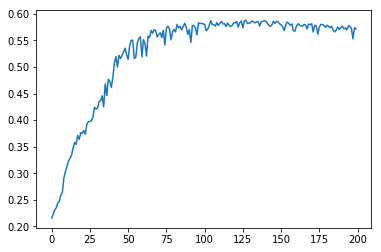

In [13]:
import matplotlib.pyplot as plt
training = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val, y_val))
val_acc = training.history['val_acc']
plt.plot(val_acc)

Text(0.5,1,'3 digits mul')

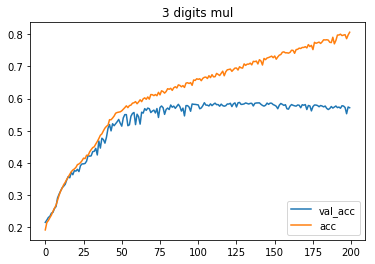

In [33]:
val_acc = training.history['val_acc']
acc = training.history['acc']
plt.figure()
plt.plot(val_acc, label = 'val_acc')
plt.plot(acc, label = 'acc')
plt.legend(loc='lower right')
plt.title('3 digits mul')

# Testing

In [31]:
print("MSG : Prediction")
#####################################################
## Try to test and evaluate your model ##############
## ex. test_x = ["555+175", "860+7  ", "340+29 "]
## ex. test_y = ["730 ", "867 ", "369 "] 
#####################################################
#####################################################
correct_ct = 0
accuracy = 0
for i in range(len(test_x)):
    ind = np.random.randint(0, len(test_x))
    rowx, rowy = test_x[np.array([ind])], test_y[np.array([ind])]
    preds = model.predict_classes(rowx, verbose=0)
    q = ctable.decode(rowx[0])
    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    if correct == guess:
        correct_ct = correct_ct + 1
    else: 
        if i < 1000:
            print(i, ' Q', q[::-1] if REVERSE else q, end=' ')
            print('T', correct, end=' ')
            print(colors.fail + '☒' + colors.close, end=' ')
            print(guess)
accuracy = correct_ct/len(test_x)
print('accu:', accuracy)

MSG : Prediction
0  Q 654*251 T 164154 ☒ 162114
1  Q 411*509 T 209199 ☒ 210399
2  Q 799*929 T 742271 ☒ 738851
3  Q 119*182 T 21658  ☒ 23258 
4  Q 121*682 T 82522  ☒ 89502 
5  Q 334*764 T 255176 ☒ 258236
6  Q 8*699   T 5592   ☒ 5562  
7  Q 370*948 T 350760 ☒ 358560
8  Q 524*22  T 11528  ☒ 11508 
9  Q 723*131 T 94713  ☒ 91793 
10  Q 971*315 T 305865 ☒ 307245
11  Q 876*351 T 307476 ☒ 309696
12  Q 220*23  T 5060   ☒ 5520  
13  Q 62*812  T 50344  ☒ 51224 
14  Q 737*662 T 487894 ☒ 403354
15  Q 504*660 T 332640 ☒ 335840
16  Q 56*749  T 41944  ☒ 42244 
17  Q 990*466 T 461340 ☒ 473340
18  Q 953*949 T 904397 ☒ 860067
19  Q 263*801 T 210663 ☒ 203363
20  Q 233*175 T 40775  ☒ 45775 
21  Q 393*824 T 323832 ☒ 328352
22  Q 973*837 T 814401 ☒ 860401
23  Q 445*214 T 95230  ☒ 96630 
24  Q 155*290 T 44950  ☒ 44150 
25  Q 823*573 T 471579 ☒ 476299
26  Q 823*100 T 82300  ☒ 83300 
27  Q 542*948 T 513816 ☒ 502796
28  Q 715*791 T 565565 ☒ 567265
29  Q 471*254 T 119634 ☒ 111754
30  Q 249*49  T 12201  ☒ 12681 
3

231  Q 362*425 T 153850 ☒ 152850
232  Q 451*691 T 311641 ☒ 312121
233  Q 823*965 T 794195 ☒ 881955
234  Q 785*418 T 328130 ☒ 322730
235  Q 789*26  T 20514  ☒ 21494 
236  Q 939*713 T 669507 ☒ 675567
237  Q 759*326 T 247434 ☒ 242114
238  Q 141*208 T 29328  ☒ 21188 
239  Q 128*759 T 97152  ☒ 95132 
240  Q 608*954 T 580032 ☒ 570952
241  Q 148*805 T 119140 ☒ 121720
242  Q 276*688 T 189888 ☒ 185248
243  Q 343*528 T 181104 ☒ 175524
244  Q 615*256 T 157440 ☒ 161340
245  Q 533*141 T 75153  ☒ 74853 
246  Q 876*522 T 457272 ☒ 451372
247  Q 801*851 T 681651 ☒ 662111
248  Q 892*470 T 419240 ☒ 418140
249  Q 594*425 T 252450 ☒ 252550
250  Q 953*482 T 459346 ☒ 471226
251  Q 472*680 T 320960 ☒ 326960
252  Q 331*647 T 214157 ☒ 218557
253  Q 486*444 T 215784 ☒ 229904
254  Q 503*405 T 203715 ☒ 294315
255  Q 760*344 T 261440 ☒ 266820
256  Q 615*284 T 174660 ☒ 176660
257  Q 893*119 T 106267 ☒ 106627
258  Q 590*920 T 542800 ☒ 573800
259  Q 598*876 T 523848 ☒ 515848
260  Q 972*971 T 943812 ☒ 907232
261  Q 352

452  Q 25*998  T 24950  ☒ 24850 
453  Q 688*966 T 664608 ☒ 658268
454  Q 818*619 T 506342 ☒ 506882
455  Q 571*462 T 263802 ☒ 263462
456  Q 671*230 T 154330 ☒ 147130
457  Q 941*720 T 677520 ☒ 676320
458  Q 835*156 T 130260 ☒ 124960
459  Q 421*954 T 401634 ☒ 302434
460  Q 731*381 T 278511 ☒ 279491
461  Q 94*948  T 89112  ☒ 83012 
462  Q 830*279 T 231570 ☒ 229570
463  Q 929*695 T 645655 ☒ 647255
464  Q 146*217 T 31682  ☒ 26522 
465  Q 579*236 T 136644 ☒ 137584
466  Q 117*854 T 99918  ☒ 101668
467  Q 69*465  T 32085  ☒ 32695 
468  Q 6*776   T 4656   ☒ 4586  
469  Q 845*364 T 307580 ☒ 319640
470  Q 386*687 T 265182 ☒ 269922
471  Q 977*354 T 345858 ☒ 354318
472  Q 969*174 T 168606 ☒ 168486
473  Q 805*319 T 256795 ☒ 252495
474  Q 115*950 T 109250 ☒ 108250
475  Q 160*808 T 129280 ☒ 132280
476  Q 506*219 T 110814 ☒ 108614
477  Q 949*303 T 287547 ☒ 290047
478  Q 933*810 T 755730 ☒ 752030
479  Q 64*397  T 25408  ☒ 25288 
480  Q 764*752 T 574528 ☒ 579488
481  Q 845*470 T 397150 ☒ 394450
482  Q 279

676  Q 265*1   T 265    ☒ 355   
677  Q 322*777 T 250194 ☒ 241054
678  Q 560*704 T 394240 ☒ 396640
679  Q 580*443 T 256940 ☒ 261640
680  Q 302*974 T 294148 ☒ 298088
681  Q 262*496 T 129952 ☒ 135372
682  Q 97*279  T 27063  ☒ 27443 
683  Q 957*29  T 27753  ☒ 28013 
684  Q 74*170  T 12580  ☒ 13380 
685  Q 493*812 T 400316 ☒ 308976
686  Q 880*847 T 745360 ☒ 748760
687  Q 313*681 T 213153 ☒ 208593
688  Q 337*551 T 185687 ☒ 189407
689  Q 743*995 T 739285 ☒ 746245
690  Q 637*7   T 4459   ☒ 4519  
691  Q 379*956 T 362324 ☒ 370924
693  Q 818*191 T 156238 ☒ 158758
694  Q 21*523  T 10983  ☒ 10466 
695  Q 759*180 T 136620 ☒ 137620
696  Q 285*986 T 281010 ☒ 282370
697  Q 747*314 T 234558 ☒ 236798
698  Q 215*376 T 80840  ☒ 75547 
699  Q 692*905 T 626260 ☒ 632460
700  Q 910*194 T 176540 ☒ 187540
701  Q 263*621 T 163323 ☒ 166303
702  Q 807*866 T 698862 ☒ 799462
703  Q 488*963 T 469944 ☒ 463344
704  Q 222*960 T 213120 ☒ 214320
705  Q 986*733 T 722738 ☒ 743978
706  Q 400*427 T 170800 ☒ 174800
707  Q 610

904  Q 96*94   T 9024   ☒ 8884  
905  Q 122*918 T 111996 ☒ 111516
906  Q 39*910  T 35490  ☒ 35590 
907  Q 886*427 T 378322 ☒ 375542
908  Q 800*83  T 66400  ☒ 66600 
909  Q 743*609 T 452487 ☒ 466687
910  Q 369*924 T 340956 ☒ 347656
911  Q 875*815 T 713125 ☒ 707675
912  Q 343*984 T 337512 ☒ 330692
913  Q 685*775 T 530875 ☒ 531175
914  Q 848*333 T 282384 ☒ 277444
915  Q 986*429 T 422994 ☒ 412734
916  Q 775*67  T 51925  ☒ 52755 
917  Q 191*740 T 141340 ☒ 145140
918  Q 714*209 T 149226 ☒ 142146
919  Q 981*385 T 377685 ☒ 383385
921  Q 565*829 T 468385 ☒ 467665
922  Q 644*121 T 77924  ☒ 75544 
923  Q 896*141 T 126336 ☒ 126576
924  Q 798*116 T 92568  ☒ 96448 
925  Q 701*232 T 162632 ☒ 165712
926  Q 236*126 T 29736  ☒ 39458 
927  Q 192*676 T 129792 ☒ 136352
928  Q 71*518  T 36778  ☒ 37778 
929  Q 912*906 T 826272 ☒ 845332
930  Q 287*658 T 188846 ☒ 183686
931  Q 616*272 T 167552 ☒ 169952
932  Q 265*66  T 17490  ☒ 16680 
933  Q 975*647 T 630825 ☒ 633675
934  Q 735*750 T 551250 ☒ 566250
935  Q 337

accu: 0.013033333333333333